<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/Text_Classification_with_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task is to create a text classification model using LSTM NN to predict whether or not an email is spam. A text generation technique is also being implemented here to deal with the data imbalance challange.

### Load and Observe Data:

In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# check system readiness
! nvidia-smi

Mon Aug 17 14:57:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |   2445MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check file counts in the directory

In [ ]:
cd /content/drive/My Drive/Data/ClassificationData/spam

In [ ]:
ls -1 |grep spam.txt | wc -l

4499


In [ ]:
cd /content/drive/My Drive/Data/ClassificationData/ham

In [ ]:
ls -1 |grep ham.txt | wc -l

1500


Load and combine text and label

In [ ]:
import glob
import os
from random import shuffle
def pre_process_data(filepath):
  positive_path = os.path.join(filepath, 'spam')
  negative_path = os.path.join(filepath, 'ham')
  pos_label = 1
  neg_label = 0
  dataset = []

  for filename in glob.glob(os.path.join(positive_path, '*.txt')):
    with open(filename, 'r', encoding='utf-8',
                 errors='ignore') as f:
      dataset.append((pos_label, f.read()))

  for filename in glob.glob(os.path.join(negative_path, '*.txt')):
    with open(filename, 'r', encoding='utf-8',
                 errors='ignore') as f:
      dataset.append((neg_label, f.read()))

  shuffle(dataset)

  return dataset

dataset = pre_process_data("/content/drive/My Drive/Data/ClassificationData")

In [ ]:
# Visually check data
dataset[:5]

[(1,
  "Subject: eshopping at our chemist - site helps you sav a lot on rneds .\nflnd a better way to sav on medicals . at our chemist - site , you have the\nbestselections on quality rneds .\nchoose our store for a range of quality medicaments on pain , swelling ,\nereection dysfunction , highcholesterol , obesity , stress , musclerelaxant and\nman ' s care .\nour company cooperates with the most experienced logistic companies\nto ensure timely shipment . , check this superssale on quality rneds at our\ncyber store .\nbrowse the affordable ones\nat cyber chemist .\nat our store , customers can gget their case profile reviewed for ffree .\nshopping for rneds is much easier . at your chemist - site , i can select from\nthese top - selling rneds . and best of all , they are much , much ccheaper than\nthose sold at the local pharrnacy . and also thank you for providing timely\nservices . - - tina d . in la\nhave mentioned . . . . we closely akin t\nrest ; but what they called ' o reality 

In [ ]:
# save the combined file
import pickle

with open('/content/drive/My Drive/dataset.data', 'wb') as file:
  pickle.dump(dataset, file)

In [ ]:
# load the saved combined file
import pickle

with open('/content/drive/My Drive/dataset.data', 'rb') as file:
    # read the data as binary data stream
    dataset = pickle.load(file)

### Data Processing:

Prepare X (input) and Y (output)

In [ ]:
X=[text[1] for text in dataset]
Y=[text[0] for text in dataset]

In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer

def Token(text_list):
  X_Cleaned=[]
  for text in X:
    pattern = r'(Subject: )'   # Remove the string shown at beginning of every text
    processed_text=re.sub(pattern, '', text)
    X_Cleaned.append(processed_text)
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(X_Cleaned)
  X_Tokenized=tokenizer.texts_to_sequences(X_Cleaned)

  
  return X_Tokenized, tokenizer.word_counts, tokenizer.word_index, tokenizer.document_count


Token_Profile=Token(X)

X_Tokenized=Token_Profile[0]


In [ ]:
# Split data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_Tokenized,Y, test_size = 0.15, random_state=80)

y_test_array=np.asarray(Y_test) # compared againt the test prediction

The ham and spam classes are highly imbalanced (1:3), the next step is to balance the two classes to about the same length. Code below generates a list of new ham texts based on original ham texts. The newly created and original ham messages will then be combined to create a balanced dataset. 

In [ ]:
import numpy as np

# Select ham cases
idxh = np.argwhere(np.array(Y_train)==0)
x_train0 = np.array(X_train)[idxh]
y_train0 = np.array(Y_train)[idxh]

# Select spam cases
idxs = np.argwhere(np.array(Y_train)==1)
x_train_Spam = np.array(X_train)[idxs]
y_train_Spam = np.array(Y_train)[idxs]


Ham_train_len=len(x_train0)
Spam_train_len=len(x_train_Spam)
print('Train Ham: {};'.format(Ham_train_len), 'Train Spam: {}'.format(Spam_train_len))

Ratio=len(x_train_Spam)/len(x_train0)
print('Spam files are {:.0f} times more than Ham files'.format(Ratio) )

Train Ham: 1262; Train Spam: 3837
Spam files are 3 times more than Ham files


#### Prepare data for text generation

In [ ]:
# reverse the index so we can search the word by index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
# the model will generate letters/chars instead of words, find all unique chars

letter_list = []
for word in list(word_index.keys()):
  for letter in word:
    if letter not in letter_list:
      letter_list.append(letter)

In [ ]:
# assign each letter/char an index

val = list(range(len(letter_list)+1)) 
letter_index = dict(zip(letter_list, val))

In [ ]:
# To put all reviews in the same list as list elements before feeding into the model

master_holder = [[]]

for record in x_train0:
  holder = []
  for idx in record[0]:  # record in a 1D array, record[0] is a list. 
    
    if idx in reverse_word_index: 
      holder.append(reverse_word_index[idx]) # search the word using index
    else:
      holder.append('UNK')

  master_holder.append(holder)
master_holder.pop(0) # remove empty space at beginning

# put all records in a list
master_list=[]
master_list = [(' '.join(master_holder[idx])) for idx in range(len(master_holder))]

print(len(master_list))
print(len(master_holder))

# put all elements in the list together creating a long string
text = ' '.join(master_list)

1262
1262


In [ ]:
# count unique letters/symbals in the text
vocab=sorted(set(text))
print(len(vocab))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# recode each char in the text using the char index it holds. Now all the docs are recoded using char index.
text_as_int = np.array([char2idx[c] for c in text])

41


In [ ]:
# Create input and target text
import tensorflow as tf

# The maximum length sentence we want for a single input in characters
seq_length = 100
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) #+1 to get both input & output length

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size 
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

#### Set up text generation model

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
print(vocab_size)

# The embedding dimension 
embedding_dim = 32

# Number of RNN units
rnn_units = 1024

81071


In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,  
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        dropout=0.2,
        recurrent_dropout=0.2,
        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 32)            1312      
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          3250176   
_________________________________________________________________
dense_2 (Dense)              (64, None, 41)            42025     
Total params: 3,293,513
Trainable params: 3,293,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer=tf.optimizers.Adam(), loss= loss)

In [ ]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/Checkpoints/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping
EPOCHS=40
history=model.fit(dataset, epochs=EPOCHS, callbacks=[EarlyStopping(monitor='loss', patience=2
), checkpoint_callback])


Epoch 1/40
275/275 [==============================] - 43s 156ms/step - loss: 1.1381
Epoch 2/40
275/275 [==============================] - 43s 157ms/step - loss: 1.1372
Epoch 3/40
275/275 [==============================] - 43s 156ms/step - loss: 1.1349
Epoch 4/40
275/275 [==============================] - 43s 155ms/step - loss: 1.1320
Epoch 5/40
275/275 [==============================] - 42s 154ms/step - loss: 1.1306
Epoch 6/40
275/275 [==============================] - 43s 155ms/step - loss: 1.1291
Epoch 7/40
275/275 [==============================] - 42s 154ms/step - loss: 1.1272
Epoch 8/40
275/275 [==============================] - 42s 155ms/step - loss: 1.1251
Epoch 9/40
275/275 [==============================] - 42s 154ms/step - loss: 1.1246
Epoch 10/40
275/275 [==============================] - 43s 155ms/step - loss: 1.1231
Epoch 11/40
275/275 [==============================] - 42s 154ms/step - loss: 1.1220
Epoch 12/40
275/275 [==============================] - 42s 154ms/step - lo

#### Generate new Ham messages

The model generates one character a time. Load the trained model parameter and set batch_size=1 (one character a time).





In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 32)             1312      
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           3250176   
_________________________________________________________________
dense_3 (Dense)              (1, None, 41)             42025     
Total params: 3,293,513
Trainable params: 3,293,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Decide the length of generated reviews 
length_holder=[]
for doc in master_list:
  length_holder.append(len(doc))

print('Mean: {}, Percentiles: {}'.format(int(np.mean(length_holder)), np.percentile(length_holder, [25, 50, 75])))

Mean: 1411, Percentiles: [ 356.    872.   1708.75]


In [ ]:
def generate_text(model, start_string):

  # Number of characters to generate for each message
  num_generate = 900

  # Vectorizing
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  temperature = 0.9

  # Here batch size == 1 to produce one token a time
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy() #=tf.multinomial()
      
      # the predicted word is then used as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
# Find the top appearing starting char (= number of reviews we need to generate and use each of these char to generate a review. Or we can radomly sample them as the start char)
n=int(Ham_train_len*2)
from collections import Counter
d=Counter(text.split())

topn_start=[]
for k, v, in d.most_common(n):
  topn_start.append(k)

In [ ]:
# store generated text in a list
%%time
from progressbar import ProgressBar
pbar=ProgressBar()
generated = []

for start_word in pbar(topn_start):
  generated.append(generate_text(model, start_word))

100% (2524 of 2524) |####################| Elapsed Time: 5:44:55 Time:  5:44:55


CPU times: user 5h 44min 5s, sys: 7min 50s, total: 5h 51min 56s
Wall time: 5h 44min 55s


In [ ]:
# save generated ham text
import pickle
pickle_out = open("/content/drive/My Drive/Data/generated_ham.pickle","wb")
pickle.dump(generated, pickle_out)
pickle_out.close()

In [ ]:
# load generated ham text
import pickle
generated = pickle.load( open( "//content/drive/My Drive/Data/generated_ham.pickle", "rb" ))

In [ ]:
generated[0]

"thering time in our time and return to the power storage level by stan holt of contracts is guardian ' s points we canadian acquisitions 28 events coming up 28 did you just wyitten a from burlington lindy when stabilities a sng business position and options delivery handling please click ebiz home enron com cllewett users the final approval of 0 051 mw of houston factor coordinator announced 1 years ago its skills to remain price of 1 710 mmcf d 97 other pipeline el paso merchant properties in development of markets and the office of this email passed the discussion to needles this year no sponsors webmust understanding with although understanding charges that will be ready to replace the supply west at the california capacity supply silsing business units west flow capacity should be outs if you look forward to says that have a happy horidoy with corporate securing natural gas markets the "

Tokenize generated text and code them into index number same form as the x_train data

#### Combine generated ham text with original text and prepare data for model input

In [ ]:
import numpy as np
import nltk
nltk.download('punkt')

In [ ]:
# assign an index to unknown words (optional) and creat it word, index dictionary
word_index["<UNK>"] = len(Token_Profile[2])+1 # unknown

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


In [ ]:
x = np.empty((len(generated)), dtype=list)
i = 0
for merged_sentence in generated:
  words = nltk.word_tokenize(''.join(merged_sentence))
  seqs = []
  for word in words:
    if word in word_index:
      seqs.append(word_index[word])
    else:
      seqs.append(word_index['<UNK>']) # for unknown

  x[i] = seqs
  i +=1


In [ ]:
# Create labels for generated text
y_train_generated = y_train_Spam[:len(generated)] # spam is longer than ham, so just chop from here

In [ ]:
# Stack generated x and y
x_train_assembled = np.concatenate((x_train_Spam, x_train0, x), axis = None)
y_train_assembled = np.concatenate((y_train_Spam, y_train0,  y_train_generated), axis = None)

print(x_train_assembled.shape,y_train_assembled.shape )

(7623,) (7623,)


In [ ]:
x_train_assembled

array([list([10238, 68, 191, 41, 153, 100, 5068, 41, 153, 54, 506, 467, 5068, 506, 1981, 68, 16, 9785, 68, 1152, 626, 2259, 411, 3240, 2, 33, 2220, 25, 324, 560, 411, 196, 118, 7, 173, 30, 578, 1904, 153, 7, 1150, 1968, 153, 257, 1151, 330, 117, 55, 233, 812, 47, 75, 37, 153, 578, 2083, 410, 7, 1150, 2012, 410, 45, 45, 45, 411, 2, 634, 21, 22, 66, 25, 347, 575, 411, 257, 1749, 1805, 2069, 1905, 924, 2027, 889, 893, 351, 1881, 2070, 1636, 1919, 2052, 2221, 2013, 617, 513, 1609, 1527, 430, 2103, 1882, 659, 1683, 2173, 2104, 1568, 2222, 411, 2113, 45, 560, 1528, 9, 3076, 63, 2113, 45, 560, 411, 15, 26, 2880, 626, 302, 2545, 2634, 58, 2, 348, 63]),
       list([1145, 1609, 1981, 68, 16, 5345, 2887, 924, 5346, 144, 21, 151, 277, 4105, 62, 155, 418, 3721, 78, 1710, 2460, 208, 626, 2259, 411, 3240, 2, 33, 2220, 25, 324, 560, 411, 196, 118, 7, 173, 30, 578, 1904, 153, 7, 1150, 1968, 153, 257, 1151, 330, 117, 55, 233, 812, 47, 75, 37, 153, 578, 2083, 410, 7, 1150, 2012, 410, 45, 45, 45, 411, 2,

In [ ]:
# all input text are padded into same # of words (256)
train_data = tf.keras.preprocessing.sequence.pad_sequences(x_train_assembled,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=256)
test_data = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=256)

### Building the Model:

Set up Bi-directional GRU model

In [ ]:
vocab_size = len(word_index)+10000 #an estimate of true vocabulary size

Sequence_length=256
Embedding_size=64
Number_neuron=128
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=Embedding_size, input_length=Sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(Number_neuron, dropout=0.4,
        recurrent_dropout=0.3)),
    tf.keras.layers.Dense(Number_neuron, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 256, 64)           5188544   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               148992    
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 5,370,561
Trainable params: 5,370,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Shuffle training data for cross validation during training cycle
Frac = 0.75 # fraction of training data used for training. Remaining is for cross validation.
idx = np.arange(len(train_data))
np.random.shuffle(idx) # shuffle then get the top 75%, equivilent to random draw

idxs = idx[:round(len(idx)*Frac)] # Select random 75% for training data
partial_x_train = train_data[idxs]
partial_y_train = y_train_assembled[idxs]

x_val = np.delete(train_data, idxs.tolist(), axis=0) # select remaining as cross validation data
y_val = np.delete(y_train_assembled, idxs.tolist(), axis=0)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_fit= model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    verbose=1)

Epoch 1/40
12/12 [==============================] - 18s 2s/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.4226 - val_acc: 0.9187
Epoch 2/40
12/12 [==============================] - 18s 2s/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.3960 - val_acc: 0.9176
Epoch 3/40
12/12 [==============================] - 18s 1s/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.4721 - val_acc: 0.9239
Epoch 4/40
12/12 [==============================] - 18s 2s/step - loss: 4.0969e-04 - acc: 1.0000 - val_loss: 0.4569 - val_acc: 0.9218
Epoch 5/40
12/12 [==============================] - 18s 2s/step - loss: 2.4701e-04 - acc: 1.0000 - val_loss: 0.4761 - val_acc: 0.9234
Epoch 6/40
12/12 [==============================] - 19s 2s/step - loss: 1.7295e-04 - acc: 1.0000 - val_loss: 0.5251 - val_acc: 0.9250
Epoch 7/40
12/12 [==============================] - 18s 1s/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.4224 - val_acc: 0.9203
Epoch 8/40
12/12 [==============================] - 18s 2s/step - loss: 0.0032

### Model Performance Evaluation:

In [ ]:
# Evaluation metrics (loss & acc) on test data
results = model.evaluate(test_data, y_test_array)

29/29 [==============================] - 3s 110ms/step - loss: 0.6801 - acc: 0.9089


Model performance over epoches

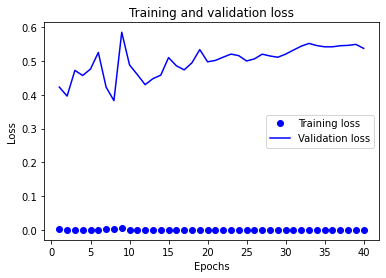

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

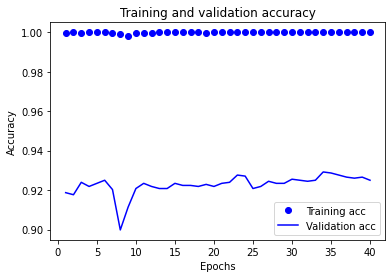

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Both loss and accuracy over epoches graphs showing the model overfits on training data.

Model performance- Precision & Recall

In [ ]:
predicted = model.predict(test_data)

predicted[predicted > 0.5] = 1
predicted[predicted <= 0.5] = 0
predictedf = predicted.flatten().astype(int)

import pandas as pd
df3 = pd.DataFrame(data=predictedf, columns=['predicted'])
refdf = pd.DataFrame(data=y_test_array, columns=['actual'])

y_actu = pd.Series(refdf['actual'], name='ACTUAL')
y_pred = pd.Series(df3['predicted'], name='PREDICTED')
predicted_results = y_pred.tolist()
truth = y_actu.tolist()

dl_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

dl_confusion

Predicted,0,1,All
Actual,,,
0,179,59,238
1,23,639,662
All,202,698,900


In [ ]:
 from sklearn.metrics import classification_report
report = classification_report(truth, predicted_results)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       238
           1       0.92      0.97      0.94       662

    accuracy                           0.91       900
   macro avg       0.90      0.86      0.88       900
weighted avg       0.91      0.91      0.91       900



Model produces high precision and recall for Spam messages but relative low recall for Ham messages (75% Ham text are correctly classified). 

To improve the performance:
*   Use simpler approch for data balancing (as shown in Text Classification Solution 1)
*   Try different 'temperature' values at the step of generating new text
*   Use L1/L2 generalization to prevent overfit




